# Solutions for the Spamfilter Exercises


In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from tidypython import gather, spread
from dplython import select, sift, mutate, summarize, group_by, X, head, DplyFrame, tail, count, DelayFunction
from plotly import io, offline # io to save a html-file of the animation
offline.init_notebook_mode() # offline for better looking interactive graphics

In [2]:
# read the data file
spam = pd.read_excel('Spam.xlsx')
spam = DplyFrame(spam)
spam.head(3)

C:\Users\mr_is_travelling\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning:

This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.



make  address   all  num3d   our  over  remove  internet  order  mail  ...  \
0  0.21     0.28  0.50    0.0  0.14  0.28    0.21      0.07   0.00  0.94  ...   
1  0.06     0.00  0.71    0.0  1.23  0.19    0.19      0.12   0.64  0.25  ...   
2  0.00     0.00  0.00    0.0  0.63  0.00    0.31      0.63   0.31  0.63  ...   

   charSemicolon  charRoundbracket  charSquarebracket  charExclamation  \
0           0.00             0.132                0.0            0.372   
1           0.01             0.143                0.0            0.276   
2           0.00             0.137                0.0            0.137   

   charDollar  charHash  capitalAve  capitalLong  capitalTotal  type  
0       0.180     0.048       5.114          101          1028  spam  
1       0.184     0.010       9.821          485          2259  spam  
2       0.000     0.000       3.537           40           191  spam  

[3 rows x 58 columns]

# Divide the data in test and training sets

Rule of thumb is to use 70 - 80% of the data to train the algorithms and the rest for testing. But the choice strongly depends on the amount of available data, the type of data and the question you are trying to answer.  

We need ensure that the sample sizes are the same as in the original data set otherwise we distort the train and test data sets. 

In [3]:
train_set = spam.sample(frac=0.8,random_state = 123) #random state is a seed value, we'll come back to that
test_set  = spam.drop(train_set.index)

In [4]:
# check distribution of each category in all three data sets

print(spam >> group_by(X.type) >> summarize(distribution = X.type.count()/spam.shape[0]))

print(train_set >> group_by(X.type) >> summarize(distribution = X.type.count()/train_set.shape[0]))

print(test_set >> group_by(X.type) >> summarize(distribution = X.type.count()/test_set.shape[0]))

      type  distribution
0  nonspam           0.5
1     spam           0.5
      type  distribution
0  nonspam      0.500431
1     spam      0.499569
      type  distribution
0  nonspam      0.498276
1     spam      0.501724


# Exercise 1

Visualise the data for the variable *charExclamation*, to see if it makes sense to define the event E = "has atleast 3% exclamation marks".

In [5]:
# you can also choose another visualisation like the following or anything else you prefer
fig = px.histogram(train_set, x="charExclamation", y="type", color="type", marginal="rug", 
             log_y = True, barmode="group", range_x=[-0.1, 10], nbins = 100, template = "none")

# change the position of the legend incase you need to save space
fig.update_layout(legend_orientation='v', legend=dict(x=0.8, y=0.58))

fig.show()

In [6]:
# Seems like 3% is a good cut off point to distinguish between spam and ham mail. 

# E: "has atleast 5% exclamation marks"
# S: "Spam mail"
# p(E|S)   = p_E_S  = p(E and S)/p(S)
# p(E|S^c) = p_E_Sc
# p(S|E)   = p_S_E

N_Total = train_set.shape[0]

# Version 1 a
# you can use pandas like this to subset the data and then count it 
N_E_Spam = train_set.type[(train_set.charExclamation >= 3) & (train_set.type == 'spam')].count()
N_Spam = train_set.type[(train_set.type == 'spam')].count()

print(N_E_Spam/N_Spam)

# Version 1 b
# or all in one go like this
p_E_S = train_set.type[(train_set.charExclamation >= 3) & 
                       (train_set.type == 'spam')].count()/train_set.type[(train_set.type == 'spam')].count()

print(p_E_S)

# Version 2
# Or you can create a pipe if you prefer to do so
N_E_Spam  = train_set >> sift((X.charExclamation >= 3) & (X.type == 'spam')) >> summarize(n = X.type.count())
N_Spam = train_set >> sift((X.type == 'spam')) >> summarize(n = X.type.count())

p_E_S = N_E_Spam.n/N_Spam.n

print(p_E_S)

0.015530629853321829
0.015530629853321829
0    0.015531
Name: n, dtype: float64


In [7]:
# p(E|S^c) = p_E_Sc = p(E and S^c)/p(S^c)

N_E_SpamC  = train_set >> sift((X.charExclamation >= 3) & (X.type != 'spam')) >> summarize(n = X.type.count())
N_SpamC = train_set >> sift((X.type != 'spam')) >> summarize(n = X.type.count())
p_E_Sc = N_E_SpamC.n/N_SpamC.n

In [8]:
# p(S|E)   = p_S_E = p(E and S)/p(E)

N_E  = train_set >> sift((X.charExclamation >= 3)) >> summarize(n = X.type.count())
p_S_E = N_E_Spam.n/N_E.n

In [9]:
print(p_E_S)
print(p_E_Sc)
print(p_S_E)

0    0.015531
Name: n, dtype: float64
0    0.002584
Name: n, dtype: float64
0    0.857143
Name: n, dtype: float64


# Answer 1

We would not classify an email as spam mail if atleast 3% of the mail consists of exclaimation marks because we get a probability of 86% which is lower than the given threashold of 98%.

# Exercise 2

Let's get the confusion matrix for the above prediction.

In [10]:
temp = train_set

# Version 1
# with pandas we do something like this 
train_set['prediction'] = "pred_ham"
train_set.loc[train_set['charExclamation'] >= 3, 'prediction'] = "pred_spam"

print(train_set >> select(X.type, X.prediction) >> head(3))

# Version 2
# with numpy we can the same thing like this
train_set['prediction'] = np.where(train_set['charExclamation'] >= 3, "pred_spam", "pred_ham")
print(train_set >> select(X.type, X.prediction) >> head(3))

confusion_mat = pd.crosstab(train_set.prediction, train_set.type, margins=True)
print(confusion_mat)

         type prediction
1523  nonspam   pred_ham
2276  nonspam   pred_ham
2057  nonspam   pred_ham
         type prediction
1523  nonspam   pred_ham
2276  nonspam   pred_ham
2057  nonspam   pred_ham
type        nonspam  spam   All
prediction                     
pred_ham       1158  1141  2299
pred_spam         3    18    21
All            1161  1159  2320


In [11]:
# Version 3
# my choice is to create a pipe, ofcourse. But I needed to use np.where and convert it's form, which is pretty ugly.
where = DelayFunction(np.where)
train1_set = temp >> mutate(prediction = where(X.charExclamation >= 3, "pred_spam", "pred_ham"))
confusion_mat = pd.crosstab(train1_set.prediction, train1_set.type, margins=True)
print(confusion_mat)

type        nonspam  spam   All
prediction                     
pred_ham       1158  1141  2299
pred_spam         3    18    21
All            1161  1159  2320


C:\Users\mr_is_travelling\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

C:\Users\mr_is_travelling\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

C:\Users\mr_is_travelling\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

C:\Users\mr_is_travelling\Anaconda3\lib\site-packages\seaborn\matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.



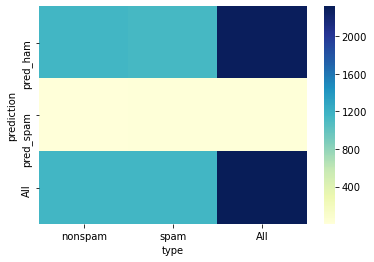

In [12]:
# One can visualise the confusion matrix with seaborn like this
import seaborn as sns
sns.heatmap(confusion_mat, cmap="YlGnBu")

In [13]:
# Measures
measures = {'Err' :  (3+1141)/2320, 'Acc' : 1 - (3+1141)/2320,
            'Sens': 18/1159, 'Spez': 1158/1161, 
            'PV+' : 18/21, 'PV-' : 1158/2299} 

print(measures)

{'Err': 0.49310344827586206, 'Acc': 0.506896551724138, 'Sens': 0.015530629853321829, 'Spez': 0.9974160206718347, 'PV+': 0.8571428571428571, 'PV-': 0.503697259678121}


The specificity of the filter is very good, but it's senstivity is seriously lacking. This means that our hit rate is really low - we are not very good at identifying spam mails. This is what we see as well if we look at the negative predictive value - 50% of the time we classify a spam mail as ham!

# Exercise 3

# Exercise 4